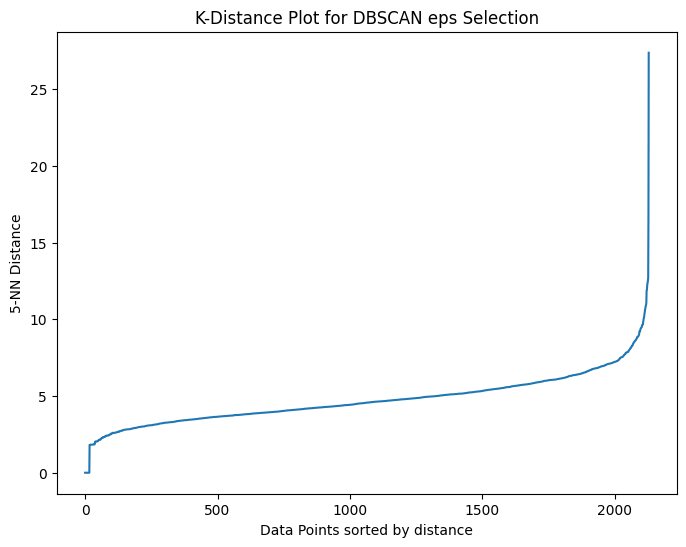

 0    2127
-1       2
Name: count, dtype: int64
DBSCAN Silhouette Score (41D): 0.6496
DBSCAN Davies-Bouldin Index (41D): 1.3370
DBSCAN Calinski-Harabasz Score (41D): 14.6066


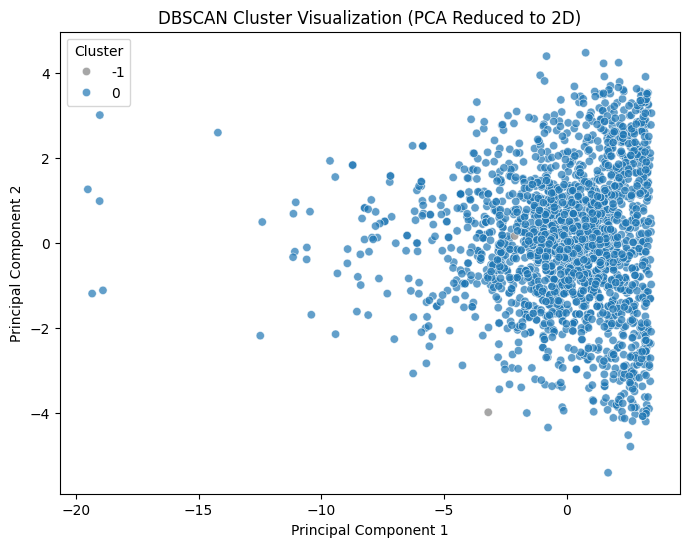

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

# Load dataset
file_path = "dataset.csv"
df = pd.read_csv(file_path)

# Drop non-numeric columns
df_numeric = df.select_dtypes(include=[np.number])  # Keep only numeric columns

# Handle missing values using KNN imputation
imputer = KNNImputer(n_neighbors=5)
df_numeric = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

# Standardize the dataset
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA to 41D
pca = PCA(n_components=41)
pca_result = pca.fit_transform(df_scaled)

# Find the optimal eps value using K-distance plot
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(pca_result)
distances, indices = neighbors_fit.kneighbors(pca_result)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.xlabel("Data Points sorted by distance")
plt.ylabel("5-NN Distance")
plt.title("K-Distance Plot for DBSCAN eps Selection")
plt.show()

# Set eps based on elbow method
eps_value = 14  # Adjust based on the K-distance plot
min_samples_value = 5  # Adjust based on dataset density

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_clusters = dbscan.fit_predict(pca_result)  # Use PCA 41D result

# Check cluster distribution
print(pd.Series(dbscan_clusters).value_counts())

# Evaluate clustering performance
if len(set(dbscan_clusters)) > 1:
    sil_score = silhouette_score(pca_result, dbscan_clusters)
    dbi_score = davies_bouldin_score(pca_result, dbscan_clusters)
    ch_score = calinski_harabasz_score(pca_result, dbscan_clusters)
else:
    sil_score, dbi_score, ch_score = -1, -1, -1  # Invalid if only one cluster

# Print results
print(f"DBSCAN Silhouette Score (41D): {sil_score:.4f}")
print(f"DBSCAN Davies-Bouldin Index (41D): {dbi_score:.4f}")
print(f"DBSCAN Calinski-Harabasz Score (41D): {ch_score:.4f}")

# Assign clusters back to DataFrame
df_numeric["DBSCAN_Cluster"] = dbscan_clusters

# Save clustered dataset
df_numeric.to_csv("dbscan_clustered_dataset.csv", index=False)

# Apply PCA to reduce dimensions to 2D for visualization
pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(df_scaled)
df_pca_2d = pd.DataFrame(data=pca_result_2d, columns=['PC1', 'PC2'])

# Define custom color palette to highlight noise (-1) as gray
palette = {cluster: "gray" if cluster == -1 else sns.color_palette("tab10")[i]
           for i, cluster in enumerate(set(dbscan_clusters))}

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca_2d['PC1'], y=df_pca_2d['PC2'], hue=dbscan_clusters, palette=palette, alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Cluster Visualization (PCA Reduced to 2D)')
plt.legend(title='Cluster')
plt.show()
